In [ ]:
from IPython import get_ipython


    #### Docs for VS Code & Jupyter notebooks [here](https://code.visualstudio.com/docs/python/jupyter-support)
    # Jump to sections of interest:
    1. Visualizing Raw Datasets
      1. [Kowalcyzk et al.](#kowal)
      2. [CellBench](#cellbench)
    2. Alignment Method Experiments Results
      1. [Iterative Closest Point (ICP)](#icp)
      2. [ICP 2](#icp2)
      3. [ScAlign](#scalign)
    3. [LISI Performance Metric](#lisi)

   ### Imports & constants

In [15]:
import time
import subprocess
from collections import defaultdict
from functools import partial
from pathlib import Path
from os import makedirs
from os.path import exists, join
import importlib

get_ipython().run_line_magic('matplotlib', 'inline')
import anndata
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['svg.fonttype'] = 'none'
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
from IPython import display
import torch
#torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import torch.optim as optim
import mnnpy

from scalign import ScAlign

import icp
import data
import embed
import alignment_task
import comparison_plots
import metrics
importlib.reload(icp)
importlib.reload(data)
importlib.reload(embed)
importlib.reload(alignment_task)
importlib.reload(comparison_plots)

N_PC = 100

DO_STANDARDIZE = False


    # Load datasets, clean them, view reduced dimensions

In [3]:
datasets = {}


# Dataset: Kowalcyzk et al.

(1022, 8354)
<class 'pandas.core.frame.DataFrame'>
Index: 1022 entries, young_LT_HSC_2 to old_MPP_180
Data columns (total 2 columns):
cell_age     1022 non-null object
cell_type    1022 non-null object
dtypes: object(2)
memory usage: 64.0+ KB
None
fitting PCA
fitting UMAP
fitting tSNE


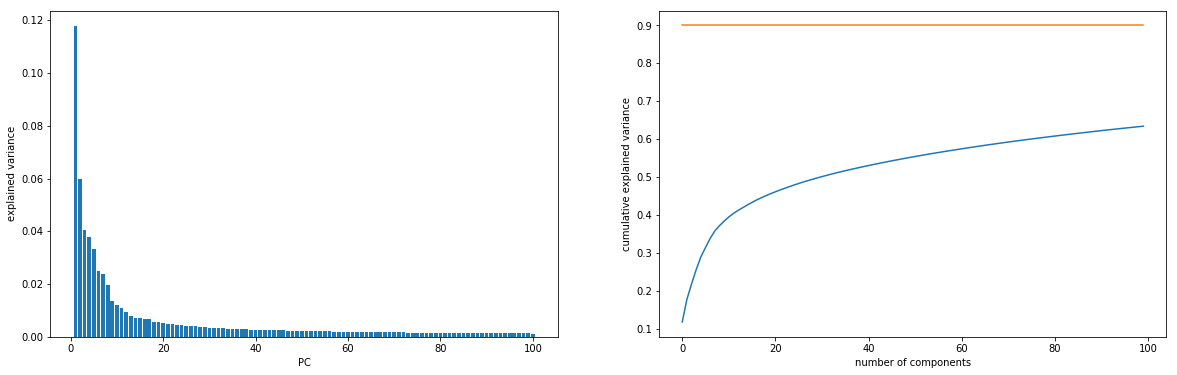

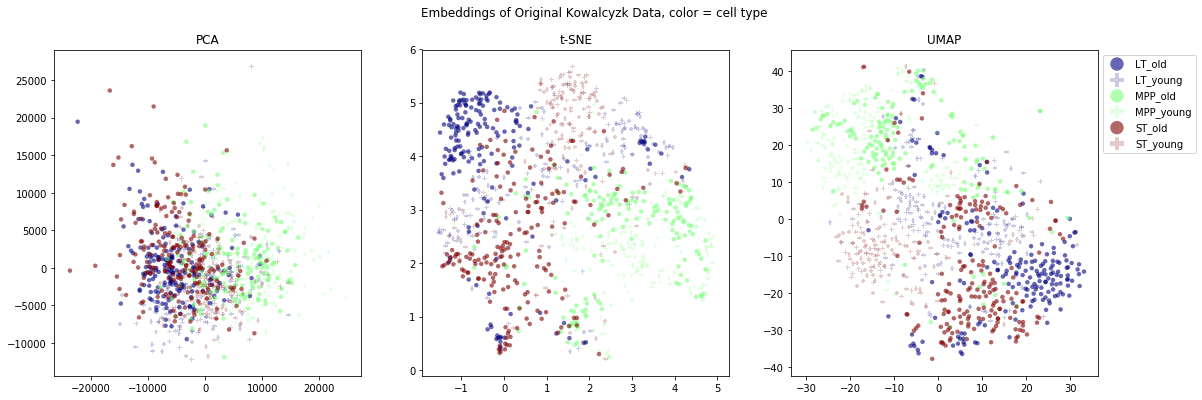

In [3]:
datasets['Kowalcyzk'] = data.get_data('Kowalcyzk')
embed.embed(datasets, 'Kowalcyzk', N_PC, do_standardize=DO_STANDARDIZE)
embed.visualize(datasets, 'Kowalcyzk', cell_type_key='cell_type', batch_key='cell_age')



# Dataset: CellBench

10x
(895, 16241)
['H1975' 'H2228' 'HCC827']
CELseq2
(240, 16876)
['H1975' 'H2228' 'HCC827']
Dropseq
(210, 13987)
['H1975' 'H2228' 'HCC827']
(1345, 12829)
<class 'pandas.core.frame.DataFrame'>
Index: 1345 entries, CELL_000001-10x to CELL_000302-Dropseq
Data columns (total 17 columns):
aligned_unmapped        1345 non-null int64
ambiguous_mapping       1345 non-null int64
cell_line               1345 non-null object
cell_line_demuxlet      1345 non-null object
demuxlet_cls            1345 non-null object
mapped_to_ERCC          1345 non-null int64
mapped_to_MT            1345 non-null int64
mapped_to_exon          1345 non-null int64
mapped_to_intron        1345 non-null int64
non_ERCC_percent        240 non-null float64
non_mt_percent          1345 non-null float64
non_ribo_percent        1345 non-null float64
number_of_genes         1345 non-null int64
outliers                1345 non-null bool
protocol                1345 non-null category
total_count_per_cell    1345 non-null int64
u

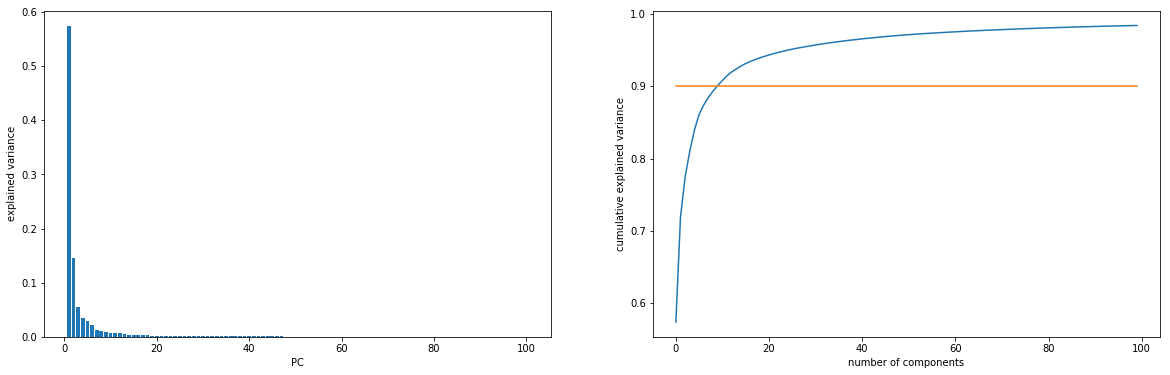

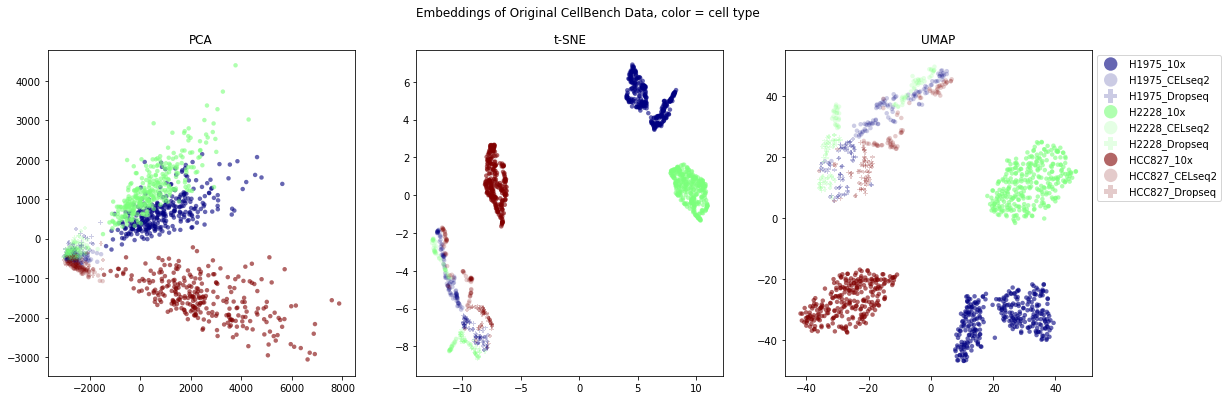

In [4]:
datasets['CellBench'] = data.get_data('CellBench')
embed.embed(datasets, 'CellBench', N_PC, do_standardize=DO_STANDARDIZE)
embed.visualize(datasets, 'CellBench', cell_type_key='cell_line_demuxlet', batch_key='protocol')


In [21]:
datasets['CellBench'].obs.index

Index(['CELL_000001-10x', 'CELL_000003-10x', 'CELL_000004-10x',
       'CELL_000005-10x', 'CELL_000006-10x', 'CELL_000007-10x',
       'CELL_000008-10x', 'CELL_000009-10x', 'CELL_000010-10x',
       'CELL_000011-10x',
       ...
       'CELL_000225-Dropseq', 'CELL_000227-Dropseq', 'CELL_000229-Dropseq',
       'CELL_000230-Dropseq', 'CELL_000233-Dropseq', 'CELL_000237-Dropseq',
       'CELL_000238-Dropseq', 'CELL_000246-Dropseq', 'CELL_000249-Dropseq',
       'CELL_000302-Dropseq'],
      dtype='object', length=1345)

In [26]:
tmp_df = datasets['CellBench'].to_df().T
print(tmp_df.columns)
tmp_df.to_csv('test_df.csv')

Index(['CELL_000001-10x', 'CELL_000003-10x', 'CELL_000004-10x',
       'CELL_000005-10x', 'CELL_000006-10x', 'CELL_000007-10x',
       'CELL_000008-10x', 'CELL_000009-10x', 'CELL_000010-10x',
       'CELL_000011-10x',
       ...
       'CELL_000225-Dropseq', 'CELL_000227-Dropseq', 'CELL_000229-Dropseq',
       'CELL_000230-Dropseq', 'CELL_000233-Dropseq', 'CELL_000237-Dropseq',
       'CELL_000238-Dropseq', 'CELL_000246-Dropseq', 'CELL_000249-Dropseq',
       'CELL_000302-Dropseq'],
      dtype='object', length=1345)


# Dataset: panc8

celseq
(992, 15436)
['acinar' 'activated_stellate' 'alpha' 'beta' 'delta' 'ductal'
 'endothelial' 'epsilon' 'gamma' 'macrophage' 'mast' 'quiescent_stellate'
 'schwann']
celseq2
(2285, 16449)
['acinar' 'activated_stellate' 'alpha' 'beta' 'delta' 'ductal'
 'endothelial' 'epsilon' 'gamma' 'macrophage' 'mast' 'quiescent_stellate'
 'schwann']
fluidigmc1
(638, 17981)
['acinar' 'activated_stellate' 'alpha' 'beta' 'delta' 'ductal'
 'endothelial' 'epsilon' 'gamma' 'macrophage' 'mast' 'quiescent_stellate'
 'schwann']
(3915, 12701)
<class 'pandas.core.frame.DataFrame'>
Index: 3915 entries, D101_5-celseq to 9th-C9_S13-fluidigmc1
Data columns (total 9 columns):
assigned_cluster    0 non-null float64
celltype            3915 non-null object
dataset             3915 non-null object
nCount_RNA          3915 non-null float64
nFeature_RNA        3915 non-null int64
orig.ident          3915 non-null object
protocol            3915 non-null category
replicate           3915 non-null object
tech           

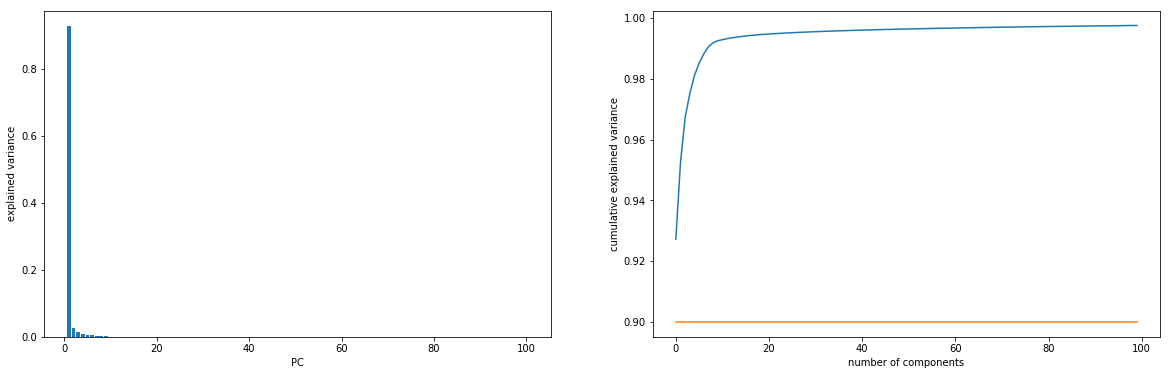

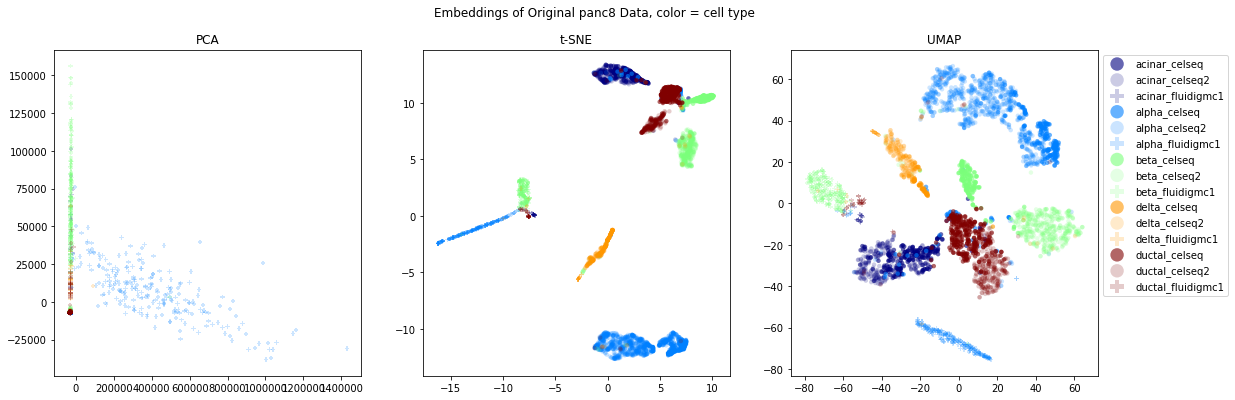

In [4]:
datasets['panc8'] = data.get_data('panc8')
embed.embed(datasets, 'panc8', N_PC, do_standardize=DO_STANDARDIZE)
embed.visualize(datasets, 'panc8', cell_type_key='celltype', batch_key='dataset')


panc8:celseq->celseq2
panc8:celseq->celseq2(\alpha)
panc8:celseq->celseq2(\beta)
panc8:celseq->celseq2
	None
computing LISI score
	ICP
(945, 100)
(2023, 100)
Looking for GPU to use...
Using device cpu
Sequential(
  (lin): Linear(in_features=100, out_features=100, bias=True)
)


Training took 00:01:05
(945, 100)
computing LISI score
	ICP2
(945, 100)
(2023, 100)
Looking for GPU to use...
Using device cpu
Sequential(
  (lin): Linear(in_features=100, out_features=100, bias=True)
)


Training took 00:01:12
(945, 100)
computing LISI score
	ICP2_xentropy
(945, 100)
(2023, 100)
Looking for GPU to use...
Using device cpu
Sequential(
  (lin): Linear(in_features=100, out_features=100, bias=True)
)


Training took 00:05:51
(945, 100)
computing LISI score
	SeuratV3
saving data for Seurat
Running command: set PATH=C:\Users\Amir\Anaconda3\envs\seuratV3\Library\mingw-w64\bin;%PATH% && C:\Users\Amir\Anaconda3\envs\seuratV3\Scripts\Rscript.exe  seurat_align.R dataset
Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname,

Instructions for updating:
Colocations handled automatically by placer.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use keras.layers.dense instead.


Instructions for updating:
Use keras.layers.batch_normalization instead.


Instructions for updating:
Use keras.layers.batch_normalization instead.


Instructions for updating:
Use keras.layers.dropout instead.


Instructions for updating:
Use keras.layers.dropout instead.


NAME OF EMBEDDED TENSOR: data_to_emb_net/net/fc4/BiasAdd:0
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


NAME OF EMBEDDED TENSOR: data_to_emb_net_1/net/fc4/BiasAdd:0
NAME OF EMBEDDED TENSOR: data_to_emb_net_2/net/fc4/BiasAdd:0
Adding source walker loss
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Adding target walker loss
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Done random initialization
Step: 0 Loss: 56.58610153198242 Alignment: 0.2926
Step: 100 Loss: 32.82569885253906 Alignment: 0.2932
Step: 200 Loss: 28.424299240112305 Alignment: 0.3055
Step: 300 Loss: 25.593399047851562 Alignment: 0.3752
Step: 400 Loss: 25.245100021362305 Alignment: 0.3819
Step: 500 Loss: 23.67020034790039 Alignment: 0.3822
Step: 600 Loss: 20.421600341796875 Alignment: 0.3668
Step: 700 Loss: 20.896099090576172 Alignment: 0.3727
Step: 800 Loss: 18.962499618530273 Alignment: 0.3987
Step: 900 Loss: 20.623300552368164 Alignment: 0.3842
Step: 1000 Loss: 18.87779998779297 Alignment: 0.3932
Step: 1100 Loss: 17.304000854492188 Alignment: 0.405
Step: 1200 Loss: 16.59630012512207 Alignment: 0.4049
Step: 1300 Loss: 15.534299850463867 Alignment: 0.3884
Step: 1400 Loss: 16.64929962158203 Alignment: 0.3762
Step: 1500 Loss: 17.805599212646484 Alignment: 0.378
Step: 1600 Loss: 16.190500259399414 Alignment: 0.3772
Step: 1700 Loss: 15.821100234985352 Alignment: 0.378
Step: 1800 Loss: 16.70

Training took 00:00:43
(945, 100)
computing LISI score
	ICP2
(945, 100)
(1179, 100)
Looking for GPU to use...
Using device cpu
Sequential(
  (lin): Linear(in_features=100, out_features=100, bias=True)
)


Training took 00:00:51
(945, 100)
computing LISI score
	ICP2_xentropy
(945, 100)
(1179, 100)
Looking for GPU to use...
Using device cpu
Sequential(
  (lin): Linear(in_features=100, out_features=100, bias=True)
)


Training took 00:05:13
(945, 100)
computing LISI score
	SeuratV3
saving data for Seurat
Running command: set PATH=C:\Users\Amir\Anaconda3\envs\seuratV3\Library\mingw-w64\bin;%PATH% && C:\Users\Amir\Anaconda3\envs\seuratV3\Scripts\Rscript.exe  seurat_align.R dataset
Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname,

Training took 00:00:55
(945, 100)
computing LISI score
	ICP2
(945, 100)
(1578, 100)
Looking for GPU to use...
Using device cpu
Sequential(
  (lin): Linear(in_features=100, out_features=100, bias=True)
)


Training took 00:00:59
(945, 100)
computing LISI score
	ICP2_xentropy
(945, 100)
(1578, 100)
Looking for GPU to use...
Using device cpu
Sequential(
  (lin): Linear(in_features=100, out_features=100, bias=True)
)


Training took 00:05:24
(945, 100)
computing LISI score
	SeuratV3
saving data for Seurat
Running command: set PATH=C:\Users\Amir\Anaconda3\envs\seuratV3\Library\mingw-w64\bin;%PATH% && C:\Users\Amir\Anaconda3\envs\seuratV3\Scripts\Rscript.exe  seurat_align.R dataset
Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname,

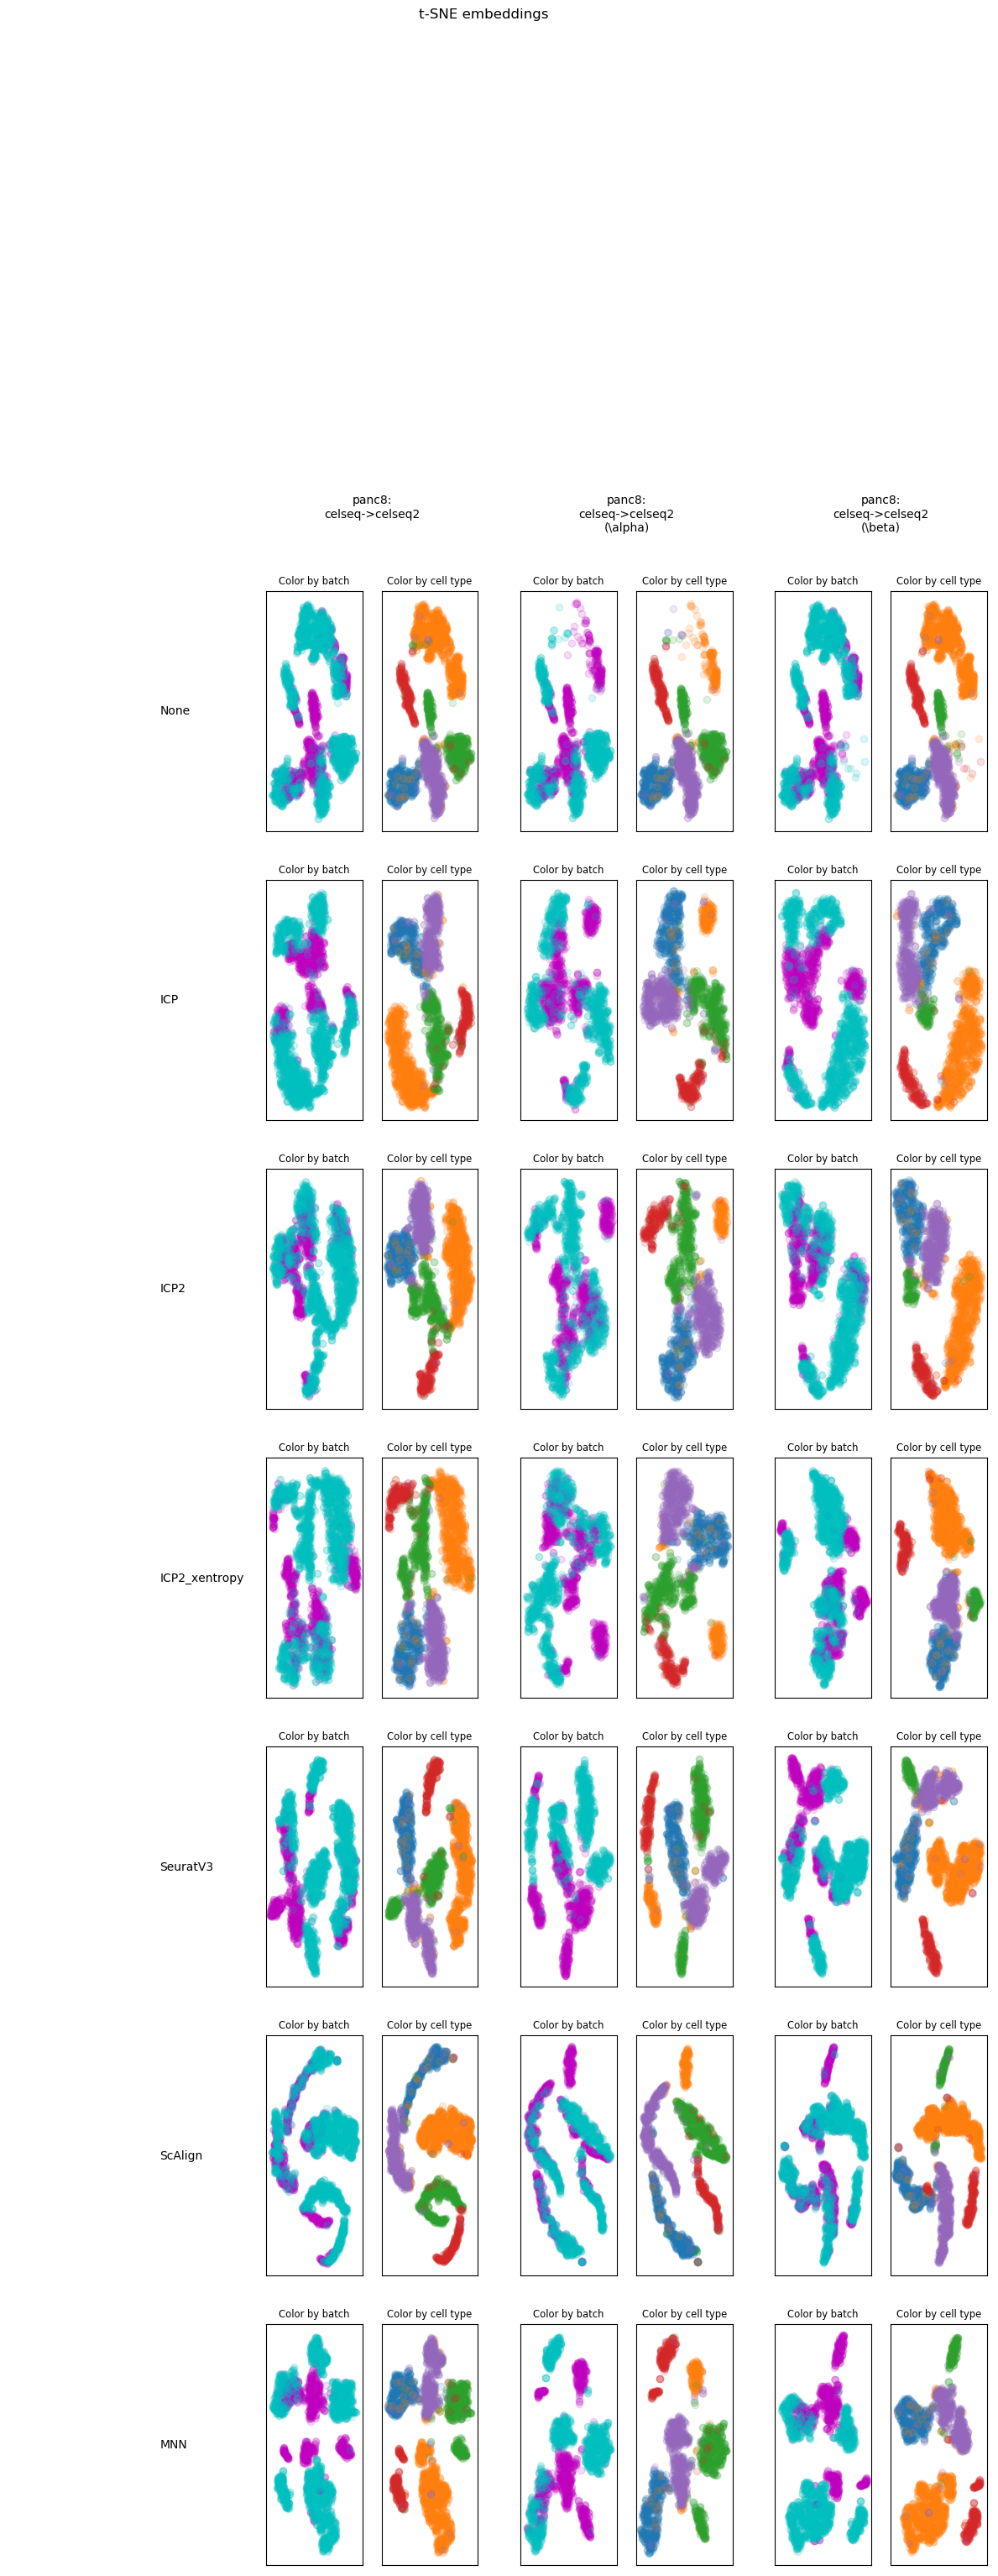

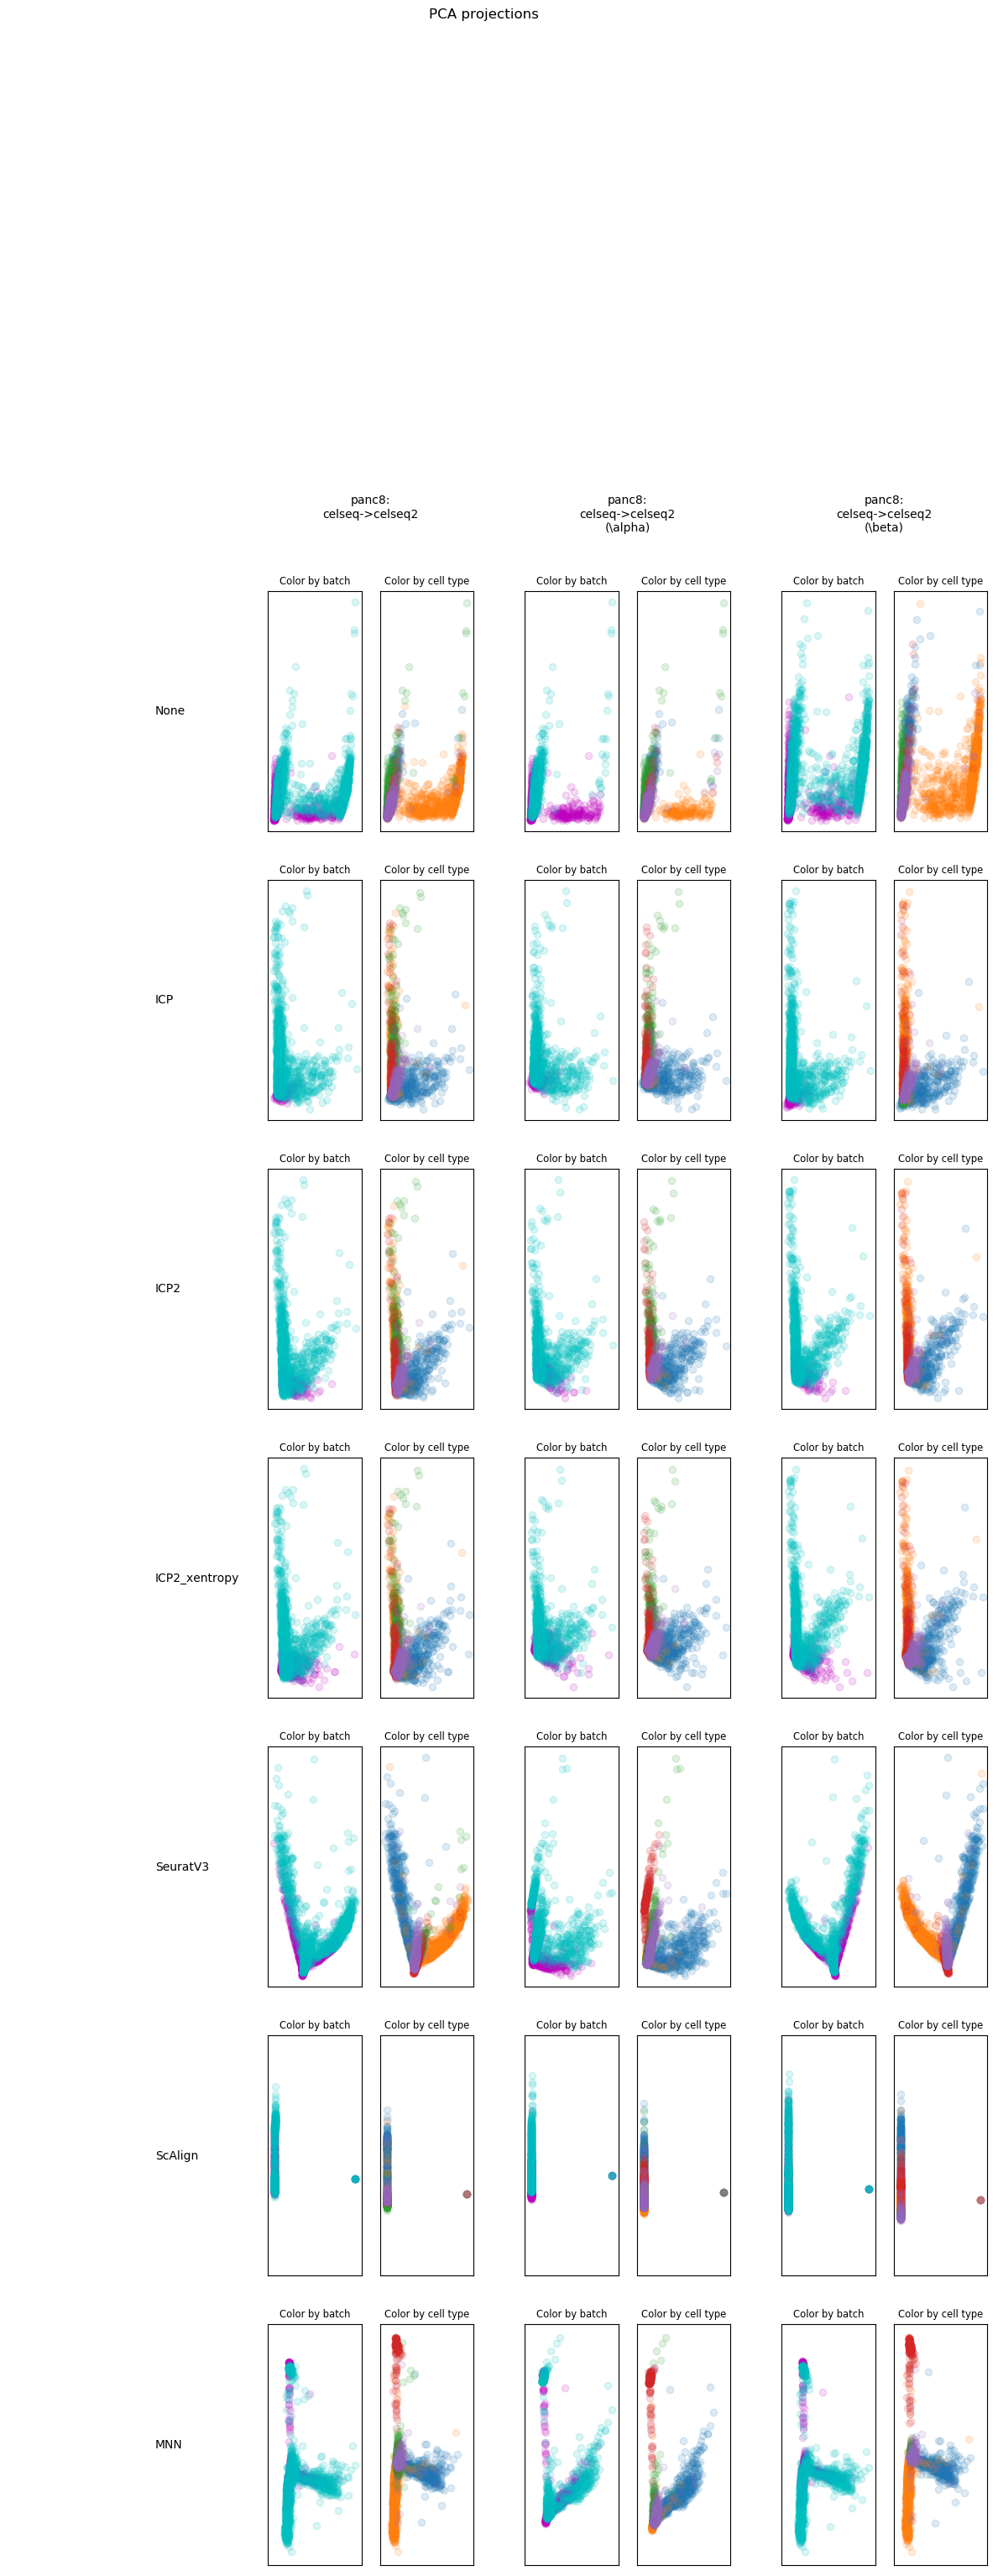

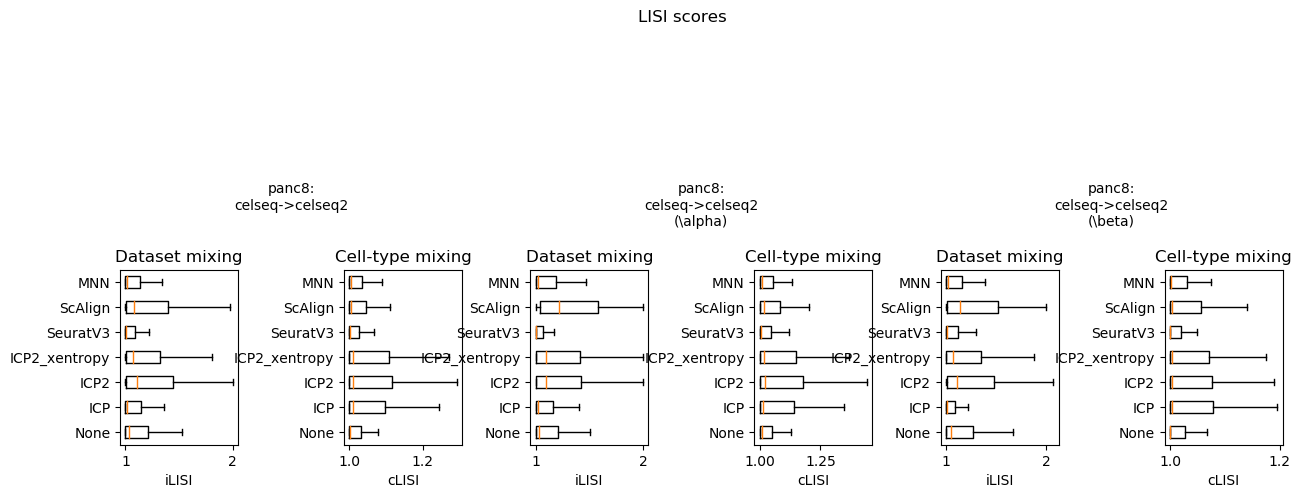

In [19]:
# Select Alignment tasks
alignment_tasks = []
alignment_tasks.append(alignment_task.AlignmentTask('panc8', 'dataset', 'celltype', 'celseq', 'celseq2'))
alignment_tasks.append(alignment_task.AlignmentTask('panc8', 'dataset', 'celltype', 'celseq', 'celseq2', 'alpha'))
alignment_tasks.append(alignment_task.AlignmentTask('panc8', 'dataset', 'celltype', 'celseq', 'celseq2', 'beta'))
# alignment_tasks.append(alignment_task.AlignmentTask('CellBench', 'protocol', 'cell_line_demuxlet', 'Dropseq', 'CELseq2'))
# alignment_tasks.append(alignment_task.AlignmentTask('CellBench', 'protocol', 'cell_line_demuxlet', 'Dropseq', 'CELseq2', 'H1975'))
# alignment_tasks.append(alignment_task.AlignmentTask('CellBench', 'protocol', 'cell_line_demuxlet', 'Dropseq', 'CELseq2', 'H2228'))
# alignment_tasks.append(alignment_task.AlignmentTask('CellBench', 'protocol', 'cell_line_demuxlet', 'Dropseq', 'CELseq2', 'HCC827'))
# alignment_tasks.append(alignment_task.AlignmentTask('Kowalcyzk', 'cell_age', 'cell_type', 'young', 'old'))
# alignment_tasks.append(alignment_task.AlignmentTask('Kowalcyzk', 'cell_age', 'cell_type', 'young', 'old', 'LT'))
# alignment_tasks.append(alignment_task.AlignmentTask('Kowalcyzk', 'cell_age', 'cell_type', 'young', 'old', 'MPP'))
# alignment_tasks.append(alignment_task.AlignmentTask('Kowalcyzk', 'cell_age', 'cell_type', 'young', 'old', 'ST'))


for task in alignment_tasks:
    print(task)
# Select alignment methods:
# methods = ['ICP2_xentropy']
# methods = ['SeuratV3']
methods = ['None', 'ICP', 'ICP2', 'ICP2_xentropy', 'SeuratV3', 'ScAlign', 'MNN']
# methods = ['None', 'ICP', 'ICP2', 'ICP2_xentropy', 'SeuratV3']
# methods = ['None', 'ICP', 'ICP2', 'SeuratV3', 'ScAlign', 'MNN']
# methods = ['None', 'ICP', 'ICP2_xentropy']
# methods = [None, 'ScAlign']
# methods = [None, 'MNN']

tsne_fig, tsne_outer_grid, pca_fig, pca_outer_grid, lisi_fig, lisi_outer_grid = comparison_plots.setup_comparison_grid_plot(alignment_tasks, methods)

def create_working_directory(out_path):
    if exists(out_path):
        time_str = time.strftime("%Y_%m_%d-%H_%M_%S")
        out_path = '{}_{}'.format(out_path, time_str)
    makedirs(out_path)
    return out_path

log_dir_root = create_working_directory('experiments')


# For each alignment task
for j, task in enumerate(alignment_tasks):
    print(task)
    if task.leave_out_ct is not None:
        task_idx = (datasets[task.ds_key].obs[task.batch_key] == task.source_batch) | ((datasets[task.ds_key].obs[task.batch_key] == task.target_batch) & (datasets[task.ds_key].obs[task.ct_key] != task.leave_out_ct))
    else:
        task_idx = (datasets[task.ds_key].obs[task.batch_key] == task.source_batch) | (datasets[task.ds_key].obs[task.batch_key] == task.target_batch)
    task_adata = datasets[task.ds_key][task_idx]
    
    lisi_scores = []
    
    # For each alignment method
    for i, method in enumerate(methods):
        print('\t{}'.format(method))
        method_key = '{}_aligned'.format(method)
        
        if method == 'None':
            comparison_plots.plot_embedding_in_grid(task_adata, 'TSNE', task, tsne_fig, tsne_outer_grid, i+1, j+1)
            comparison_plots.plot_embedding_in_grid(task_adata, 'PCA', task, pca_fig, pca_outer_grid, i+1, j+1)
            lisi_scores.append(metrics.lisi2(task_adata.obsm['PCA'], task_adata.obs, [task.batch_key, task.ct_key], perplexity=30))
        elif method == 'ICP' or method == 'ICP2' or method=='ICP2_act' or method == 'ICP2_act+lin' or method == 'ICP2_xentropy':
            log_dir = join(log_dir_root, '{}_{}'.format(task.as_path(), method))
            if not exists(log_dir):
                makedirs(log_dir)
            A, B, type_index_dict, combined_meta = alignment_task.get_source_target(datasets, task, use_PCA=True)
            print(A.shape)
            print(B.shape)
            if method == 'ICP':
                #aligner = icp.ICP(A, B, type_index_dict, loss_function=icp.closest_point_loss, max_iters=200, verbose=False)
                aligner = icp.ICP(A, B, type_index_dict,
                                  working_dir=log_dir,
                                  mse_loss_function=icp.closest_point_loss,
                                  n_layers=1,
                                  bias=True,
                                  #act='tanh',
                                  epochs=15,
                                  lr=1e-3,
                                  momentum=0.9,
                                  l2_reg=0.,
                                  xentropy_loss_weight=0.0)
            elif method == 'ICP2':
                loss_fcn = partial(icp.relaxed_match_loss, source_match_threshold=0.5, do_mean=False)
                #aligner = icp.ICP(A, B, type_index_dict, loss_function=loss_fcn, max_iters=200, verbose=False)
                aligner = icp.ICP(A, B, type_index_dict,
                                  working_dir=log_dir,
                                  mse_loss_function=loss_fcn,
                                  n_layers=1,
                                  bias=True,
                                  #act='tanh',
                                  epochs=15,
                                  lr=1e-3,
                                  momentum=0.9,
                                  l2_reg=0.,
                                  xentropy_loss_weight=0.0)
#             elif method == 'ICP2_act':
#                 loss_fcn = partial(icp.relaxed_match_loss, source_match_threshold=0.5)
#                 aligner = icp.ICP(A, B, type_index_dict, act='tanh', loss_function=loss_fcn, max_iters=200, verbose=False)
#             elif method == 'ICP2_act+lin':
#                 loss_fcn = partial(icp.relaxed_match_loss, source_match_threshold=0.5)
#                 aligner = icp.ICP(A, B, type_index_dict, n_layers=2, act='tanh', loss_function=loss_fcn, max_iters=200, verbose=False)
            elif method == 'ICP2_xentropy':
                loss_fcn = partial(icp.relaxed_match_loss, source_match_threshold=0.5, do_mean=False)
                # aligner = icp.ICP(A, B, type_index_dict, loss_function=loss_fcn, max_iters=200, verbose=False, use_xentropy_loss=True)
                aligner = icp.ICP(A, B, type_index_dict,
                                  working_dir=log_dir,
                                  mse_loss_function=loss_fcn,
                                  n_layers=1,
                                  bias=True,
                                  #act='tanh',
                                  epochs=15,
                                  lr=1e-3,
                                  momentum=0.9,
                                  l2_reg=0.,
                                  xentropy_loss_weight=10.0,
                                  plot_every_n_steps=5)
            aligner_fcn = lambda x: aligner(torch.from_numpy(x).float()).detach().numpy()
            #standardizing because it was fitted with standardized data (see ICP code)
            scaler = StandardScaler().fit(np.concatenate((A,B)))
            A = scaler.transform(A)
            B = scaler.transform(B)
            A = aligner_fcn(A)
            print(A.shape)
            n_samples = task_adata.shape[0]
            n_dims = A.shape[1]
            task_adata.obsm[method_key] = np.zeros((n_samples, n_dims))
            a_idx = np.where(task_adata.obs[task.batch_key] == task.source_batch)[0]
            b_idx = np.where(task_adata.obs[task.batch_key] == task.target_batch)[0]
            task_adata.obsm[method_key][a_idx, :] = A
            task_adata.obsm[method_key][b_idx, :] = B
            #lisi_scores.append(metrics.lisi2(task_adata.obsm[method_key], task_adata.obs, [task.batch_key, task.ct_key], perplexity=30)
            task_adata.obsm[method_key+'_TSNE'] = TSNE(n_components=2).fit_transform(task_adata.obsm[method_key])
            task_adata.obsm[method_key+'_PCA'] = PCA(n_components=2).fit_transform(task_adata.obsm[method_key])
            comparison_plots.plot_embedding_in_grid(task_adata, method_key+'_TSNE', task, tsne_fig, tsne_outer_grid, i+1, j+1)
            comparison_plots.plot_embedding_in_grid(task_adata, method_key+'_PCA', task, pca_fig, pca_outer_grid, i+1, j+1)
            lisi_scores.append(metrics.lisi2(task_adata.obsm[method_key], task_adata.obs, [task.batch_key, task.ct_key], perplexity=30))
        elif method == 'ScAlign':
            #idx = (datasets['CellBench'].obs['cell_line_demuxlet'] == 'H2228') & (datasets['CellBench'].obs['protocol'] == 'CELseq2')
            #datasets['CellBench'] = datasets['CellBench'][ ~idx ,:]
            sc_align = ScAlign(
                object1_name=task.source_batch,
                object2_name=task.target_batch, 
                object_var=task.batch_key,
                label_var=task.ct_key,
                data_use='PCA',
                user_options={
                    #'max_steps': 100,
                    'logdir': 'scAlign_model',
                    'log_results': True,
                    'early_stop': True
                },
                device='CPU')
            sc_align.fit_encoder(task_adata)
            print('Trained encoder saved to: {}'.format(sc_align.trained_encoder_path_))
            task_adata.obsm[method_key] = sc_align.encode(task_adata.obsm['PCA'])
            task_adata.obsm[method_key+'_TSNE'] = TSNE(n_components=2).fit_transform(task_adata.obsm[method_key])
            task_adata.obsm[method_key+'_PCA'] = PCA(n_components=2).fit_transform(task_adata.obsm[method_key])
            comparison_plots.plot_embedding_in_grid(task_adata, method_key+'_PCA', task, pca_fig, pca_outer_grid, i+1, j+1)
            comparison_plots.plot_embedding_in_grid(task_adata, method_key+'_TSNE', task, tsne_fig, tsne_outer_grid, i+1, j+1)
            lisi_scores.append(metrics.lisi2(task_adata.obsm[method_key], task_adata.obs, [task.batch_key, task.ct_key], perplexity=30))
        elif method == 'MNN':
            A_idx = task_adata.obs[task.batch_key] == task.source_batch
            B_idx = task_adata.obs[task.batch_key] == task.target_batch
            A_X = task_adata[A_idx].obsm['PCA']
            B_X = task_adata[B_idx].obsm['PCA']
#             # standardizing
#             scaler = StandardScaler().fit(np.concatenate((A_X,B_X)))
#             A_X = scaler.transform(A_X)
#             B_X = scaler.transform(B_X)
            mnn_adata_A = anndata.AnnData(X=A_X, obs=task_adata[A_idx].obs)
            mnn_adata_B = anndata.AnnData(X=B_X, obs=task_adata[B_idx].obs)
            corrected = mnnpy.mnn_correct(mnn_adata_A, mnn_adata_B)
            task_adata.obsm[method_key] = np.zeros(corrected[0].shape)
            task_adata.obsm[method_key][np.where(A_idx)[0]] = corrected[0].X[:mnn_adata_A.shape[0]]
            task_adata.obsm[method_key][np.where(B_idx)[0]] = corrected[0].X[mnn_adata_A.shape[0]:]
            task_adata.obsm[method_key+'_TSNE'] = TSNE(n_components=2).fit_transform(task_adata.obsm[method_key])
            task_adata.obsm[method_key+'_PCA'] = PCA(n_components=2).fit_transform(task_adata.obsm[method_key])
            comparison_plots.plot_embedding_in_grid(task_adata, method_key+'_PCA', task, pca_fig, pca_outer_grid, i+1, j+1)
            comparison_plots.plot_embedding_in_grid(task_adata, method_key+'_TSNE', task, tsne_fig, tsne_outer_grid, i+1, j+1)
            lisi_scores.append(metrics.lisi2(task_adata.obsm[method_key], task_adata.obs, [task.batch_key, task.ct_key], perplexity=30))
        elif method == 'SeuratV3':
            print("saving data for Seurat")
            #task_adata.write('_tmp_adata_for_seurat.h5ad')
            df = task_adata.to_df()
            df.T.to_csv('_tmp_counts.csv')
            task_adata.obs.to_csv('_tmp_meta.csv')
            # Run seurat
            #cmd = "C:\\Users\\samir\\Anaconda3\\envs\\seuratV3\\Scripts\\Rscript.exe  seurat_align.R {}".format(task.batch_key)
            cmd = r"set PATH=C:\Users\Amir\Anaconda3\envs\seuratV3\Library\mingw-w64\bin;%PATH% && C:\Users\Amir\Anaconda3\envs\seuratV3\Scripts\Rscript.exe  seurat_align.R {}".format(task.batch_key)
            print("Running command: {}".format(cmd))
            console_output = subprocess.run(cmd.split(), shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
            console_output = console_output.stdout.decode('UTF-8')
            print(console_output)
            aligned_adata = anndata.read_loom("_tmp_adata_for_seurat.loom")
            print('done loading loom')
            #print(type(aligned_adata.X))
            print('todense...')
            task_adata.obsm[method_key] = aligned_adata.X.todense()
            print('tsne')
            task_adata.obsm[method_key+'_TSNE'] = TSNE(n_components=2).fit_transform(task_adata.obsm[method_key])
            print('pca')
            task_adata.obsm[method_key+'_PCA'] = PCA(n_components=2).fit_transform(task_adata.obsm[method_key])
            comparison_plots.plot_embedding_in_grid(task_adata, method_key+'_PCA', task, pca_fig, pca_outer_grid, i+1, j+1)
            comparison_plots.plot_embedding_in_grid(task_adata, method_key+'_TSNE', task, tsne_fig, tsne_outer_grid, i+1, j+1)
            print('compute lisi...')
            lisi_scores.append(metrics.lisi2(task_adata.obsm[method_key], task_adata.obs, [task.batch_key, task.ct_key], perplexity=30))

    comparison_plots.plot_lisi(lisi_scores, methods, task, lisi_fig, lisi_outer_grid, 1, j)
tsne_fig.savefig(join(log_dir_root, 'comparison_tsne.pdf'))
tsne_fig.savefig(join(log_dir_root, 'comparison_tsne.svg'))
tsne_fig.savefig(join(log_dir_root, 'comparison_tsne.png'))
pca_fig.savefig(join(log_dir_root, 'comparison_pca.pdf'))
pca_fig.savefig(join(log_dir_root, 'comparison_pca.svg'))
pca_fig.savefig(join(log_dir_root, 'comparison_pca.png'))
lisi_fig.savefig(join(log_dir_root, 'comparison_scores.pdf'))
lisi_fig.savefig(join(log_dir_root, 'comparison_scores.svg'))
lisi_fig.savefig(join(log_dir_root, 'comparison_scores.png'))

